In [1]:
# cross section preprocessing based on peaks of elevation

In [2]:
# given cross section, find all peaks in elevation
# can also use this to compute subbasin valley depth - as elevation difference between thalweg and ridges, atleast in 2d

In [24]:
from slopes.__main__ import process_topography, load_input, setup_wbt, smooth_flowlines
from slopes.profile.network_xsections import network_xsections
from slopes.utils import observe_values

import matplotlib.pyplot as plt

In [7]:
wbt = setup_wbt("../working_dir/")

In [8]:
dem, flowlines = load_input("../data/input/dem.tif", "../data/input/flowlines.shp")

In [14]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt, sigma=5)
smoothed = smooth_flowlines(aligned_flowlines)

In [65]:
xsections = network_xsections(smoothed, 10, 300, 3)

In [66]:
values = observe_values(xsections, dataset[['dem', 'slope', 'curvature', 'hand']])

In [67]:
def analyze_relative_position(elevation, distances):
    """
    Analyze each point's position relative to local maxima/minima to identify
    parallel valleys.
    """
    def find_local_extrema(elev, dist, window=5):
        peaks = []
        valleys = []
        for i in range(window, len(elev) - window):
            window_slice = elev[i-window:i+window]
            if elev[i] == max(window_slice):
                peaks.append(i)
            if elev[i] == min(window_slice):
                valleys.append(i)
        return peaks, valleys
    
    def calculate_prominence(idx, elev):
        """Calculate topographic prominence of a point"""
        left_max = max(elev[:idx]) if idx > 0 else elev[idx]
        right_max = max(elev[idx:]) if idx < len(elev)-1 else elev[idx]
        return min(elev[idx] - left_max, elev[idx] - right_max)
    
    # Find major divides and valleys
    peaks, valleys = find_local_extrema(elevation, distances)
    
    return {
        'peaks': peaks,
        'valleys': valleys,
        'prominences': [calculate_prominence(i, elevation) for i in peaks]
    }

In [90]:
profile = values.loc[(values['streamID'] == 11) & (values['xsID'] == 25)]
elevation = profile['dem']
distances = profile['alpha']

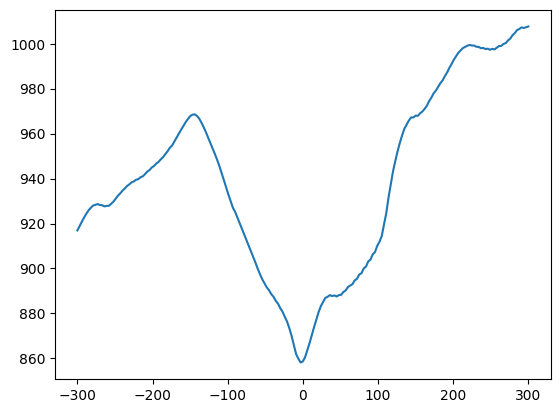

In [91]:
plt.plot(distances, elevation)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

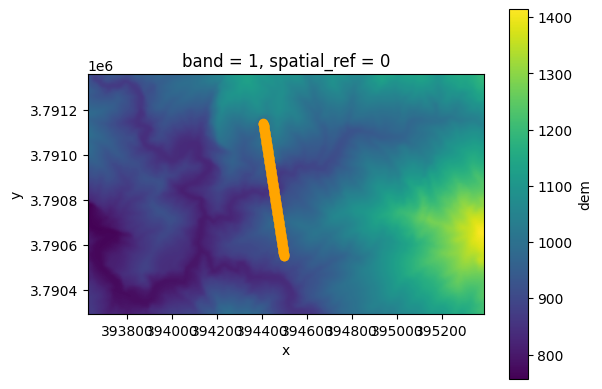

In [92]:
fig, ax = plt.subplots()
dataset['dem'].plot(ax=ax)
profile.plot(ax=ax, color='orange')

In [93]:
result = analyze_relative_position(elevation.values, distances.values)

In [94]:
result

{'peaks': [9, 52, 174],
 'valleys': [12, 99, 183],
 'prominences': [np.float64(-79.01600471560982),
  np.float64(-39.079977023230754),
  np.float64(-8.21789207073482)]}

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

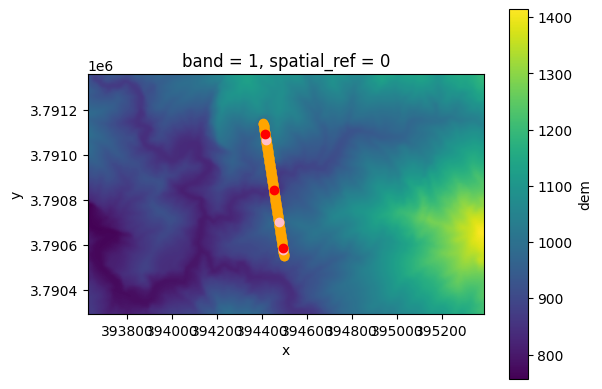

In [96]:
fig, ax = plt.subplots()
dataset['dem'].plot(ax=ax)
profile.plot(ax=ax, color='orange')
profile.iloc[result['peaks']].plot(ax=ax, color='pink')
profile.iloc[result['valleys']].plot(ax=ax, color='red')

In [97]:
# alternative scipy peak detection, prominence threshold